In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras import backend as K
import tensorflow as tf

In [4]:
# ! pip install tensorflow

In [5]:
import keras
config = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True,device_count = {'GPU': 1 , 'CPU': 56}) )
keras.backend.set_session(config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [6]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [7]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [8]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


In [9]:
X_train.shape

(50000, 32, 32, 3)

In [10]:
X_test.shape

(10000, 32, 32, 3)

In [11]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [12]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

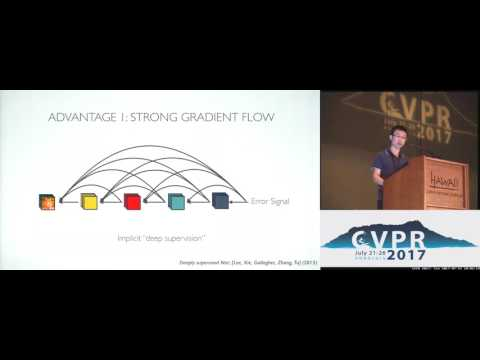

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [13]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
print(len(model.layers))

262


In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 78s 102ms/step - loss: 1.7187 - accuracy: 0.3524 - val_loss: 1.6062 - val_accuracy: 0.4232
Epoch 2/10
391/391 [==============================] - 37s 94ms/step - loss: 1.3829 - accuracy: 0.4883 - val_loss: 1.3495 - val_accuracy: 0.5169
Epoch 3/10
391/391 [==============================] - 38s 96ms/step - loss: 1.2379 - accuracy: 0.5463 - val_loss: 1.1956 - val_accuracy: 0.5768
Epoch 4/10
391/391 [==============================] - 38s 97ms/step - loss: 1.1237 - accuracy: 0.5931 - val_loss: 1.2230 - val_accuracy: 0.5891
Epoch 5/10
391/391 [==============================] - 38s 97ms/step - loss: 1.0488 - accuracy: 0.6229 - val_loss: 1.5108 - val_accuracy: 0.5358
Epoch 6/10
391/391 [==============================] - 38s 97ms/step - loss: 0.9915 - accuracy: 0.6443 - val_loss: 1.0291 - val_accuracy: 0.6479
Epoch 7/10
391/391 [==============================] - 38s 97ms/step - loss: 0.9515 - accuracy: 0.6586 - val_loss: 1.1797 - val_accuracy

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.9221 - accuracy: 0.6791
Test loss: 0.9220625758171082
Test accuracy: 0.679099977016449


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
del model

### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

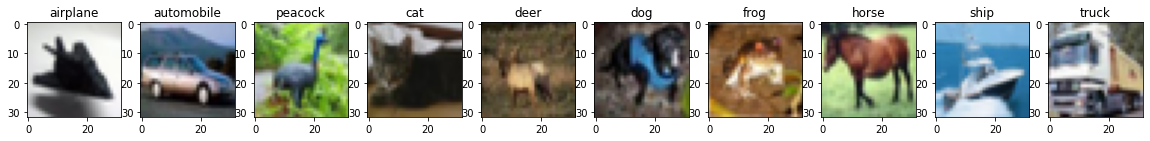

In [16]:
## visualizing the classes
fig = plt.figure(figsize=(20,11))
classes = ['airplane','automobile','peacock','cat','deer','dog','frog','horse','ship','truck']
for i in range(10):
      plt.subplot(1,10,i+1)
      plt.imshow(X_train[np.where(y_train==i)[0][0]])
      plt.title(classes[i])

In [17]:
#### scale the pixels
## https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# scale pixels
def scale_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255
	test_norm = test_norm / 255
	# return normalized images
	return train_norm, test_norm

In [18]:
X_train,X_test = scale_pixels(X_train,X_test)

In [19]:
# convert to one hot encoding 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

### let's change the  dropout_rate to 0,alter strides to (5,5) and number of filters

In [20]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer='he_uniform' ,use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression),(5,5),kernel_initializer='he_uniform' ,use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [21]:
num_filter = 10
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)
Batchnorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(Batchnorm,32, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, 16, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [22]:
model = Model(inputs=[input],outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 10)   750         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 32, 32, 10)   40          conv2d_52[0][0]                  
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 10)   40          batch_normalization_52[0][0]     
____________________________________________________________________________________________

##### we have 0.8 million trainable params

In [24]:
from keras.preprocessing.image import ImageDataGenerator

###Data Augmentation
### https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/
# rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15
def augment_data():
    datagen = ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.09,
      horizontal_flip=True,
      zoom_range=0.2,
      shear_range=15
      )
    return datagen
datagen = augment_data()
datagen.fit(X_train)

In [ ]:
### https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'best_weights_epoch20.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
batch_size=64
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
781/781 [==============================] - 153s 148ms/step - loss: 1.7250 - accuracy: 0.3659 - val_loss: 1.6352 - val_accuracy: 0.4372
Epoch 2/20
781/781 [==============================] - 114s 145ms/step - loss: 1.4152 - accuracy: 0.4820 - val_loss: 1.3549 - val_accuracy: 0.5060
Epoch 3/20
781/781 [==============================] - 116s 148ms/step - loss: 1.2497 - accuracy: 0.5505 - val_loss: 1.5288 - val_accuracy: 0.4906
Epoch 4/20
781/781 [==============================] - 119s 153ms/step - loss: 1.1252 - accuracy: 0.5960 - val_loss: 1.1729 - val_accuracy: 0.6021
Epoch 5/20
781/781 [==============================] - 116s 148ms/step - loss: 1.0303 - accuracy: 0.6335 - val_loss: 1.1565 - val_accuracy: 0.6027
Epoch 6/20
781/781 [==============================] - 116s 149ms/step - loss: 0.9658 - accuracy: 0.6551 - val_loss: 1.0424 - val_accuracy: 0.6391
Epoch 7/20
781/781 [==============================] - 116s 149ms/step - loss: 0.9110 - accuracy: 0.6756 - val_loss: 0.8783 -

In [ ]:
# Test the model
model.load_weights(path)
score = model.evaluate(X_test, y_test, verbose=1)      
print('Test loss:', score[0])       
print('Test accuracy:', score[1])   

313/313 [==============================] - 20s 65ms/step - loss: 0.6417 - accuracy: 0.7849
Test loss: 0.641657829284668
Test accuracy: 0.7849000096321106


In [ ]:
path = 'best_weights_epoch55.h5'

In [ ]:
model.load_weights('best_weights_epoch40.h5')
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=15,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
781/781 [==============================] - 156s 151ms/step - loss: 0.4178 - accuracy: 0.8550 - val_loss: 0.5698 - val_accuracy: 0.8134
Epoch 2/15
781/781 [==============================] - 115s 147ms/step - loss: 0.4090 - accuracy: 0.8568 - val_loss: 0.5355 - val_accuracy: 0.8202
Epoch 3/15
781/781 [==============================] - 115s 147ms/step - loss: 0.4031 - accuracy: 0.8618 - val_loss: 0.5208 - val_accuracy: 0.8301
Epoch 4/15
781/781 [==============================] - 115s 147ms/step - loss: 0.3976 - accuracy: 0.8615 - val_loss: 0.5456 - val_accuracy: 0.8216
Epoch 5/15
781/781 [==============================] - 115s 148ms/step - loss: 0.3936 - accuracy: 0.8625 - val_loss: 0.4491 - val_accuracy: 0.8510
Epoch 6/15
781/781 [==============================] - 115s 148ms/step - loss: 0.3928 - accuracy: 0.8623 - val_loss: 0.5136 - val_accuracy: 0.8268
Epoch 7/15
781/781 [==============================] - 115s 147ms/step - loss: 0.3825 - accuracy: 0.8661 - val_loss: 0.4635 -

In [ ]:
!cp -r '/content/best_weights_epoch55.h5'  '/content/drive/MyDrive/'

In [ ]:
path = 'best_weights_epoch85.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('best_weights_epoch55.h5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=30,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
781/781 [==============================] - 157s 153ms/step - loss: 0.3638 - accuracy: 0.8736 - val_loss: 0.4842 - val_accuracy: 0.8436
Epoch 2/30
781/781 [==============================] - 115s 147ms/step - loss: 0.3564 - accuracy: 0.8768 - val_loss: 0.6951 - val_accuracy: 0.7971
Epoch 3/30
781/781 [==============================] - 118s 151ms/step - loss: 0.3524 - accuracy: 0.8761 - val_loss: 0.5342 - val_accuracy: 0.8328
Epoch 4/30
781/781 [==============================] - 115s 148ms/step - loss: 0.3473 - accuracy: 0.8776 - val_loss: 0.4074 - val_accuracy: 0.8682
Epoch 5/30
781/781 [==============================] - 115s 147ms/step - loss: 0.3444 - accuracy: 0.8798 - val_loss: 0.4847 - val_accuracy: 0.8424
Epoch 6/30
781/781 [==============================] - 117s 150ms/step - loss: 0.3414 - accuracy: 0.8816 - val_loss: 0.4684 - val_accuracy: 0.8437
Epoch 7/30
781/781 [==============================] - 117s 150ms/step - loss: 0.3393 - accuracy: 0.8811 - val_loss: 0.4696 -

In [ ]:
!cp -r '/content/best_weights_epoch85.h5'  '/content/drive/MyDrive/'

In [ ]:
path = 'best_weights_epoch115.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('best_weights_epoch85.h5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=30,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
781/781 [==============================] - 159s 155ms/step - loss: 0.2775 - accuracy: 0.9017 - val_loss: 0.4250 - val_accuracy: 0.8604
Epoch 2/30
781/781 [==============================] - 121s 154ms/step - loss: 0.2778 - accuracy: 0.9017 - val_loss: 0.3903 - val_accuracy: 0.8730
Epoch 3/30
781/781 [==============================] - 120s 154ms/step - loss: 0.2780 - accuracy: 0.9028 - val_loss: 0.4269 - val_accuracy: 0.8666
Epoch 4/30
781/781 [==============================] - 117s 150ms/step - loss: 0.2742 - accuracy: 0.9043 - val_loss: 0.4757 - val_accuracy: 0.8550
Epoch 5/30
781/781 [==============================] - 117s 150ms/step - loss: 0.2723 - accuracy: 0.9037 - val_loss: 0.4582 - val_accuracy: 0.8588
Epoch 6/30
781/781 [==============================] - 118s 151ms/step - loss: 0.2720 - accuracy: 0.9042 - val_loss: 0.4763 - val_accuracy: 0.8529
Epoch 7/30
781/781 [==============================] - 117s 150ms/step - loss: 0.2643 - accuracy: 0.9076 - val_loss: 0.4387 -

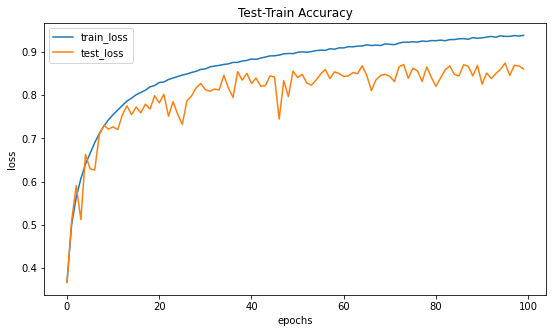

In [ ]:
#### visualize loss and layers for 100 epochs
import seaborn as sns
def plot_accuracy(train_loss,test_loss):
    fig = plt.figure(figsize=(9,5))
    sns.lineplot(np.arange(100),train_loss,label='train_loss')
    sns.lineplot(np.arange(100),test_loss,label='test_loss')
    plt.title('Test-Train Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
plot_accuracy(history['accuracy'][:100],history['val_accuracy'][:100])

In [ ]:
path = 'best_weights_epoch135.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('best_weights_epoch115.h5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
781/781 [==============================] - 123s 152ms/step - loss: 0.2464 - accuracy: 0.9125 - val_loss: 0.4448 - val_accuracy: 0.8660
Epoch 2/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2394 - accuracy: 0.9154 - val_loss: 0.4264 - val_accuracy: 0.8678
Epoch 3/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2428 - accuracy: 0.9146 - val_loss: 0.4666 - val_accuracy: 0.8594
Epoch 4/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2419 - accuracy: 0.9137 - val_loss: 0.4198 - val_accuracy: 0.8711
Epoch 5/20
781/781 [==============================] - 118s 151ms/step - loss: 0.2370 - accuracy: 0.9173 - val_loss: 0.4397 - val_accuracy: 0.8677
Epoch 6/20
781/781 [==============================] - 118s 151ms/step - loss: 0.2396 - accuracy: 0.9161 - val_loss: 0.4658 - val_accuracy: 0.8606
Epoch 7/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2361 - accuracy: 0.9169 - val_loss: 0.4918 -

In [ ]:
path = 'best_weights_epoch155.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('best_weights_epoch135.h5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
781/781 [==============================] - 123s 152ms/step - loss: 0.2206 - accuracy: 0.9218 - val_loss: 0.3823 - val_accuracy: 0.8819
Epoch 2/20
781/781 [==============================] - 120s 153ms/step - loss: 0.2188 - accuracy: 0.9247 - val_loss: 0.3703 - val_accuracy: 0.8842
Epoch 3/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2201 - accuracy: 0.9229 - val_loss: 0.4306 - val_accuracy: 0.8683
Epoch 4/20
781/781 [==============================] - 118s 151ms/step - loss: 0.2195 - accuracy: 0.9221 - val_loss: 0.4011 - val_accuracy: 0.8799
Epoch 5/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2172 - accuracy: 0.9235 - val_loss: 0.5441 - val_accuracy: 0.8507
Epoch 6/20
781/781 [==============================] - 118s 151ms/step - loss: 0.2171 - accuracy: 0.9238 - val_loss: 0.3852 - val_accuracy: 0.8819
Epoch 7/20
781/781 [==============================] - 117s 150ms/step - loss: 0.2157 - accuracy: 0.9233 - val_loss: 0.3958 -

In [ ]:
path = 'best_weights_epoch185.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('best_weights_epoch155.h5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=30,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
781/781 [==============================] - 289s 325ms/step - loss: 0.2166 - accuracy: 0.9234 - val_loss: 0.3505 - val_accuracy: 0.8853
Epoch 2/30
781/781 [==============================] - 252s 322ms/step - loss: 0.2083 - accuracy: 0.9269 - val_loss: 0.4370 - val_accuracy: 0.8720
Epoch 3/30
781/781 [==============================] - 252s 322ms/step - loss: 0.2087 - accuracy: 0.9259 - val_loss: 0.3576 - val_accuracy: 0.8885
Epoch 4/30
781/781 [==============================] - 251s 321ms/step - loss: 0.2052 - accuracy: 0.9279 - val_loss: 0.4450 - val_accuracy: 0.8709
Epoch 5/30
781/781 [==============================] - 251s 322ms/step - loss: 0.2071 - accuracy: 0.9259 - val_loss: 0.3825 - val_accuracy: 0.8850
Epoch 6/30
781/781 [==============================] - 250s 320ms/step - loss: 0.2048 - accuracy: 0.9282 - val_loss: 0.4575 - val_accuracy: 0.8689
Epoch 7/30
781/781 [==============================] - 251s 322ms/step - loss: 0.2066 - accuracy: 0.9261 - val_loss: 0.4060 -

 #### let's use SGD optimizer with momentum 0.6 and learning rate 0.001 to converge faster to optimal solution 

In [32]:
from keras.optimizers import  SGD

In [ ]:

model.load_weights('best_weights_epoch185.h5')


path = 'best_weights_epoch205.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.6,learning_rate=0.001),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]//batch_size, 
                    epochs = 20, validation_data =(X_test, y_test), callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
390/390 [==============================] - 156s 297ms/step - loss: 0.1792 - accuracy: 0.9370 - val_loss: 0.3536 - val_accuracy: 0.8930
Epoch 2/20
390/390 [==============================] - 113s 290ms/step - loss: 0.1709 - accuracy: 0.9398 - val_loss: 0.3498 - val_accuracy: 0.8952
Epoch 3/20
390/390 [==============================] - 111s 284ms/step - loss: 0.1693 - accuracy: 0.9402 - val_loss: 0.3473 - val_accuracy: 0.8960
Epoch 4/20
390/390 [==============================] - 111s 285ms/step - loss: 0.1648 - accuracy: 0.9417 - val_loss: 0.3457 - val_accuracy: 0.8964
Epoch 5/20
390/390 [==============================] - 114s 291ms/step - loss: 0.1633 - accuracy: 0.9437 - val_loss: 0.3446 - val_accuracy: 0.8973
Epoch 6/20
390/390 [==============================] - 111s 284ms/step - loss: 0.1607 - accuracy: 0.9442 - val_loss: 0.3433 - val_accuracy: 0.8976
Epoch 7/20
390/390 [==============================] - 111s 283ms/step - loss: 0.1602 - accuracy: 0.9438 - val_loss: 0.3416 -

In [ ]:
model.load_weights('best_weights_epoch205.h5')

path = 'best_weights_epoch215.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.6,learning_rate=0.001),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]//batch_size, 
                    epochs = 10, validation_data =(X_test, y_test), callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
390/390 [==============================] - 110s 274ms/step - loss: 0.1534 - accuracy: 0.9461 - val_loss: 0.3416 - val_accuracy: 0.8999
Epoch 2/10
390/390 [==============================] - 108s 278ms/step - loss: 0.1512 - accuracy: 0.9466 - val_loss: 0.3415 - val_accuracy: 0.9004
Epoch 3/10
390/390 [==============================] - 112s 286ms/step - loss: 0.1474 - accuracy: 0.9488 - val_loss: 0.3395 - val_accuracy: 0.8999
Epoch 4/10
390/390 [==============================] - 112s 287ms/step - loss: 0.1508 - accuracy: 0.9481 - val_loss: 0.3398 - val_accuracy: 0.9005
Epoch 5/10
390/390 [==============================] - 110s 283ms/step - loss: 0.1464 - accuracy: 0.9482 - val_loss: 0.3400 - val_accuracy: 0.9002
Epoch 6/10
390/390 [==============================] - 112s 288ms/step - loss: 0.1506 - accuracy: 0.9477 - val_loss: 0.3434 - val_accuracy: 0.8999
Epoch 7/10
390/390 [==============================] - 109s 280ms/step - loss: 0.1479 - accuracy: 0.9475 - val_loss: 0.3406 -

In [33]:
model.load_weights('best_weights_epoch215.h5')
# model.optimizer = SGD()
# keras.backend.set_value(model.optimizer.momentum, 0.7)
# keras.backend.set_value(model.optimizer.lr, 0.001)

path = 'best_weights_epoch225.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.6,learning_rate=0.001),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]//batch_size, 
                    epochs = 10, validation_data =(X_test, y_test), callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
390/390 [==============================] - 158s 302ms/step - loss: 0.1525 - accuracy: 0.9464 - val_loss: 0.3418 - val_accuracy: 0.8997
Epoch 2/10
390/390 [==============================] - 112s 287ms/step - loss: 0.1480 - accuracy: 0.9478 - val_loss: 0.3422 - val_accuracy: 0.8995
Epoch 3/10
390/390 [==============================] - 112s 286ms/step - loss: 0.1490 - accuracy: 0.9479 - val_loss: 0.3419 - val_accuracy: 0.8997
Epoch 4/10
390/390 [==============================] - 112s 287ms/step - loss: 0.1480 - accuracy: 0.9484 - val_loss: 0.3413 - val_accuracy: 0.9009
Epoch 5/10
390/390 [==============================] - 112s 286ms/step - loss: 0.1488 - accuracy: 0.9481 - val_loss: 0.3405 - val_accuracy: 0.9009
Epoch 6/10
390/390 [==============================] - 112s 286ms/step - loss: 0.1487 - accuracy: 0.9476 - val_loss: 0.3414 - val_accuracy: 0.8996
Epoch 7/10
390/390 [==============================] - 111s 286ms/step - loss: 0.1461 - accuracy: 0.9488 - val_loss: 0.3421 -

In [34]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 8s 26ms/step - loss: 0.3405 - accuracy: 0.9009
Test loss: 0.340536504983902
Test accuracy: 0.9009000062942505


In [ ]:
# Save the trained weights in to .h5 formath
# model.save_weights("DNST_model_100epochs.h6") 
# print("Saved model to disk")

Saved model to disk


#### After training with 215 epochs we could get val-accuracy of 0.9009